In [2]:
%config Completer.use_jedi = False  # enable code auto-completion
import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt    # library providing tools for plotting data

import datetime
import timeit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures    # function to generate polynomial and interaction features
from sklearn.linear_model import LinearRegression, HuberRegressor    # classes providing Linear Regression with ordinary squared error loss and Huber loss, respectively
from sklearn.metrics import mean_squared_error, mean_absolute_error    # function to calculate mean squared error 

from sklearn.neural_network import MLPRegressor

RAND_STATE = 81


In [3]:
# Data downloaded from FMI
filenames  = ['csv-35e8cb05-1688-451e-b8a2-79a400016fb7.csv',
              'csv-0027a0da-4810-4ec7-b613-507c0d0b0574.csv',
              'csv-111376c7-f8e5-48cf-be8d-6d71254f676f.csv',
              'csv-e37ac627-0e7c-4f44-bce9-5fe782aeae63.csv']
# 2020-2022
# 2017-2020
# 2014-2016
# 2011-2013

In [6]:
# Data processing
debug_metadata = []
data = []

select_time = ['00:00', '04:00', '08:00', '12:00', '16:00', '20:00']
labels_dict = {'Year':'y', 'Time':'time'} # used to renaming column labels
new_labels  = data_pd.columns.tolist()

for filename in filenames:
    FMIRawData  = pd.read_csv(filename)
    data_pd     = FMIRawData.drop(['Time zone'],axis=1)
    # Rename columns
    for i, s in enumerate(new_labels):
        new_label = labels_dict.get(new_labels[i])
        if new_label != None:
            new_labels[i] = new_label
    data_pd.columns = new_labels
    # now the column labels are
    # ['y', 'm', 'd', 'time', 'Pressure (msl) (hPa)', 'Precipitation amount (mm)', 'Air temperature (degC)']
    #print(new_labels) #debug
    data_pd     = data_pd[data_pd['time'].isin(select_time)]
    pruned      = data_pd.dropna(axis = 0, how = 'any')
    debug_metadata.append([np.shape(data_pd), np.shape(pruned)])
    data.extend(pruned.to_numpy())
    
    print(f'Added {filename}')

LOC_YEAR            = 0
LOC_MONTH           = 1
LOC_DAY             = 2
LOC_TIME            = 3
LOC_PRESSURE        = 4
LOC_PRECIPITATION   = 5
LOC_AIR_TEMPERATURE = 6

Added csv-35e8cb05-1688-451e-b8a2-79a400016fb7.csv
Added csv-0027a0da-4810-4ec7-b613-507c0d0b0574.csv
Added csv-111376c7-f8e5-48cf-be8d-6d71254f676f.csv
Added csv-e37ac627-0e7c-4f44-bce9-5fe782aeae63.csv


In [7]:
# Data inspection
print(np.shape(data), ' total data') #(24182, 7)
for item in debug_metadata:
    print(f'{item[0]} unpruned, {item[0][0] - item[1][0]} rejects, {item[1]} after pruning')

(24182, 7)  total data
(4741, 7) unpruned, 23 rejects, (4718, 7) after pruning
(6571, 7) unpruned, 10 rejects, (6561, 7) after pruning
(6577, 7) unpruned, 82 rejects, (6495, 7) after pruning
(6577, 7) unpruned, 169 rejects, (6408, 7) after pruning


In [8]:
### Build the feature and label vectors

# debugging function
erroneous = [] # for debugging purposes
def print_erroneous(): 
    # Requires the variable "erroneous" to work
    # type: list of [int, int]
    print('Printing all jumps to the next 00:00 timestamp')
    for i in erroneous:
        print('Jumped from ', i[0], ' to ', i[1])
    return

# Init variables
N = 6  # number of measurements per day
X = []
y = []
first = 0 
#LOC_YEAR            = 0
#LOC_MONTH           = 1
#LOC_DAY             = 2
#LOC_TIME            = 3
#LOC_PRESSURE        = 4
#LOC_PRECIPITATION   = 5
#LOC_AIR_TEMPERATURE = 6
#DEBUG_LOWB = 0
#DEBUG_UPB  = 2120
debug = []
i = first

while i < (len(data) -1):
    year  = data[i][LOC_YEAR]
    month = data[i][LOC_MONTH]
    day   = data[i][LOC_DAY]
    today    = datetime.datetime(year, month, day)
    tomorrow = today + datetime.timedelta(days = 1)
    features = []
    labels   = []
    
    # find valid data for the datapoint
    # N = 6 measurements required
    features = [today.month, today.day]
    for t in range(N):
        ind_t = i+t
        if ind_t >= len(data): #OoB
            continue
        row = data[ind_t]
        if (row[LOC_TIME] == select_time[t]): # timestamp matches
            features.extend([row[LOC_PRESSURE], row[LOC_PRECIPITATION], row[LOC_AIR_TEMPERATURE]])
        else:
            erroneous.append(i) # debug
            # find the next 00:00 timestamp and jump to it
            f = t
            while True:
                ind_f = i+f
                if ind_f >= len(data):
                    break
                f_row = data[ind_f]
                if (f_row[LOC_TIME] == select_time[0]): # found the 00:00
                    erroneous.append([i, i+f]) # debugging
                    break
                f = f +1
            i = i + f
            continue
            
    # N = 6 measurements found
    # find the min and max temp from tomorrow
    mintemp = np.PINF  # positive infinity
    maxtemp = np.NINF  # negative inf
    pred_count = 0
    minfound = False
    maxfound = False
    for d in range(2*N):
        ind_d = i+N+d
        if ind_d >= len(data):
            continue
        row  = data[ind_d]
        rowy = row[LOC_YEAR]
        rowm = row[LOC_MONTH]
        rowd = row[LOC_DAY]
        if ((rowy != tomorrow.year) or (rowm != tomorrow.month) or (rowd != tomorrow.day)):
            continue
        if row[LOC_AIR_TEMPERATURE] < mintemp:
            minfound = True
            mintemp  = row[LOC_AIR_TEMPERATURE]
        if row[LOC_AIR_TEMPERATURE] > maxtemp:
            maxfound = True
            maxtemp  = row[LOC_AIR_TEMPERATURE]
        pred_count = pred_count +1
        
    if (minfound and maxfound): # if both min and max temperature found, record datapoint
        labels = [mintemp, maxtemp]
        X.append(features)
        y.append(labels)
    else:
        debug.append([i, pred_count])
    
    i = i + N

X = np.array(X)
y = np.array(y)

In [9]:
print(f'shapes of X and y: {np.shape(X)}, {np.shape(y)}')
print(f'shape of debug array: {np.shape(debug)}')
#data[2097:2120,:]

shapes of X and y: (3898, 20), (3898, 2)
shape of debug array: (71, 2)


Text(0.5, 0, 'days since 2011.1.1')

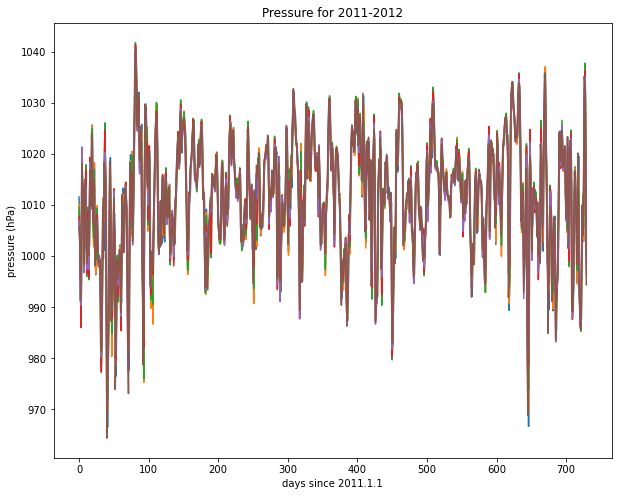

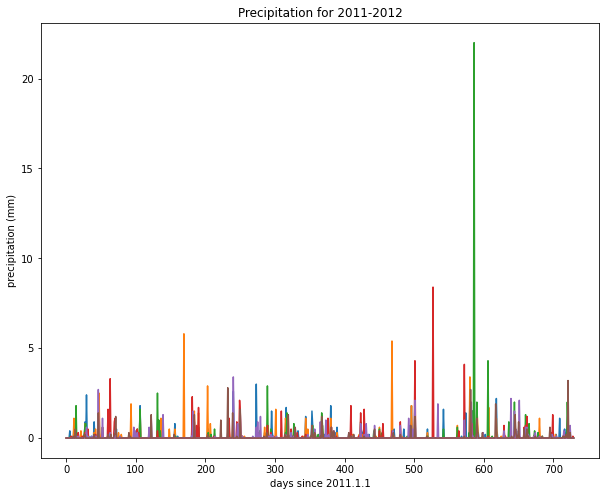

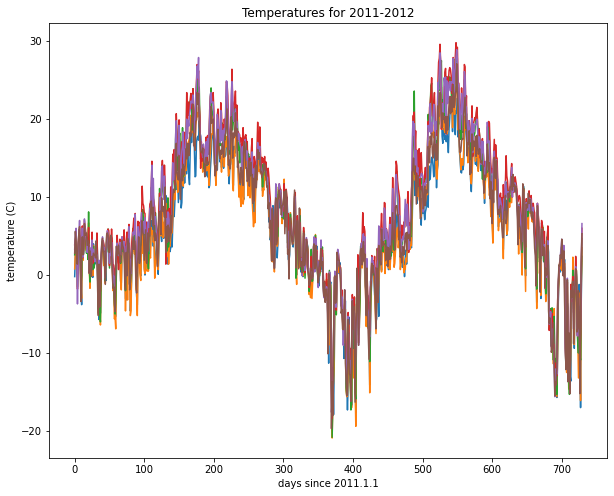

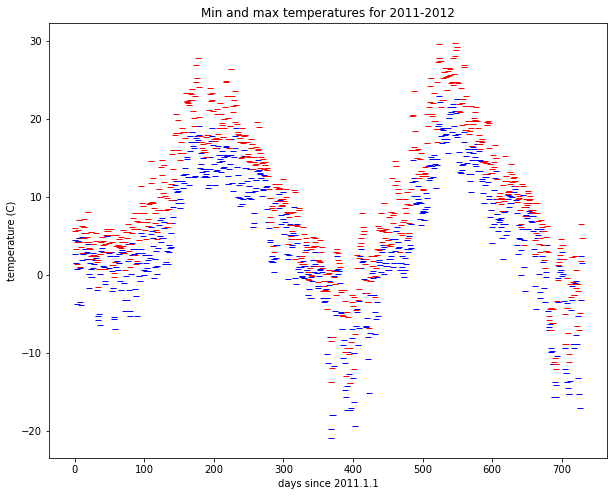

In [151]:
# Plot the data for the year
# note: datapoint X format: month, day, [precipitation, air temp] x6

plotting_loc = [2,5,8,11,14,17]
incr         = np.ones(len(plotting_loc), dtype = int)
# plot the pressures
plt.figure(figsize=(10,8))
plt.title('Pressure for 2011-2012')
plt.plot(X[0:365*2, plotting_loc])
plt.ylabel('pressure (hPa)')
plt.xlabel('days since 2011.1.1')

# plot the precipitations
plt.figure(figsize=(10,8))
plt.title('Precipitation for 2011-2012')
plt.plot(X[0:365*2, plotting_loc + incr])
plt.ylabel('precipitation (mm)')
plt.xlabel('days since 2011.1.1')

# plot the temperatures
plt.figure(figsize=(10,8))
plt.title('Temperatures for 2011-2012')
plt.plot(X[0:365*2, plotting_loc + incr*2])
plt.ylabel('temperature (C)')
plt.xlabel('days since 2011.1.1')

# plot the max and min temperatures
plt.figure(figsize=(10,8))
plt.title('Min and max temperatures for 2011-2012')
plt.plot(y[0:365*2,0], 'b_')
plt.plot(y[0:365*2,1], 'r_')
plt.ylabel('temperature (C)')
plt.xlabel('days since 2011.1.1')


In [25]:
# Model training

# split the data into three sets: training, validation, testing
X_train, X_rem = train_test_split(X,     test_size = 0.5, random_state = RAND_STATE)
y_train, y_rem = train_test_split(y,     test_size = 0.5, random_state = RAND_STATE)
X_val, X_test  = train_test_split(X_rem, test_size = 0.2, random_state = RAND_STATE)
y_val, y_test  = train_test_split(y_rem, test_size = 0.2, random_state = RAND_STATE)

# ensure they're numpy arrays to use the notation A[m, n]
y_train = np.array(y_train)
y_val   = np.array(y_val)
y_test  = np.array(y_test)


In [158]:
# first method: polynomial regression using linear regression and kernel method, and mean squared error

degree = 0
poly_tr_errors, poly_val_errors = [], []
poly_predictors = []
lin_regr      = LinearRegression(fit_intercept=False) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
print('-- Polynomial regression, MSE as the loss function --')

-- Polynomial regression, MSE as the loss function --


In [161]:
# iterating multiple times manually
timerstart    = timeit.default_timer() #
print(f'Degree: {degree}')
degree        = degree + 1
poly          = PolynomialFeatures(degree=degree)     # generate polynomial features
X_train_poly  = poly.fit_transform(X_train)           # fit and transform the raw features
X_val_poly    = poly.fit_transform(X_val)
lin_regr.fit(X_train_poly, y_train)                   # apply linear regression to these new features and labels
poly_predictors.append([degree, lin_regr])

y_pred_train  = lin_regr.predict(X_train_poly)
tr_error      = mean_squared_error(y_train, y_pred_train)
y_pred_val    = lin_regr.predict(X_val_poly)
val_error     = mean_squared_error(y_val, y_pred_val)

poly_tr_errors .append(tr_error)
poly_val_errors.append(val_error)

timerstop     = timeit.default_timer()
print(f' Training error: {tr_error}, Validation error: {val_error}',
      f'Time taken: {timerstop - timerstart}')

if val_error / tr_error > 100:
    print(f'[!] Significant difference in validation and training errors:',
          f'\n{val_error} / {tr_error} = {val_error/tr_error}')

Degree: 3, Training error: 0.9251338167479085, Validation error: 274033.58865168004 Time taken: 7.497043177485466
[!] Significant difference in validation and training errors: 
274033.58865168004 / 0.9251338167479085 = 296209.6765795256


In [162]:
print('Training errors, Validation errors')
poly_tr_and_val_errors = np.array([poly_tr_errors, poly_val_errors]).T
print(poly_tr_and_val_errors)

Training errors, Validation errors
[[4.06545762e+00 4.05745078e+00]
 [3.12604270e+00 4.55985463e+00]
 [9.25133817e-01 2.74033589e+05]]


In [33]:
# Plot the validation results
choice = 1
deg                     = poly_predictors[choice][0]
selected_poly_predictor = poly_predictors[choice][1]
mserr_poly     = poly_val_errors[choice]
print(f'Shape of yhat_poly_val: {np.shape(yhat_poly_val)}')

Shape of yhat_poly_val: (1559, 2)


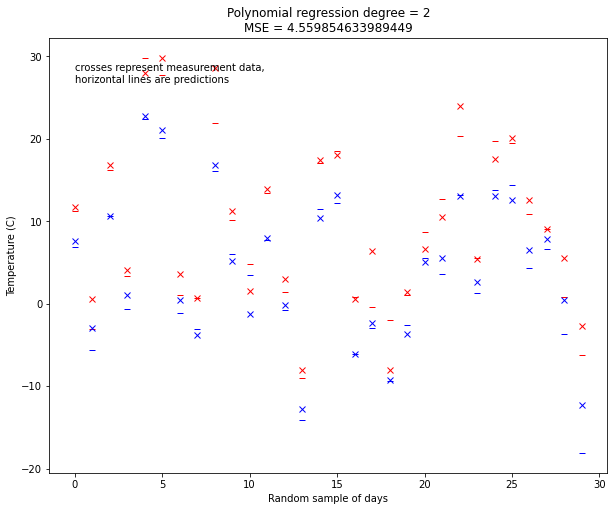

In [84]:
plt.figure(figsize=(10,8))
plt.title(f'Polynomial regression degree = {deg}' + 
          f'\nMSE = {mserr_poly}')
plt.text(0, 0.9*max(yhat_poly_val[0:30, 1]), 'crosses represent measurement data, \nhorizontal lines are predictions')
plt.xlabel('Random sample of days')
plt.ylabel('Temperature (C)')
plt.plot(yhat_poly_val[0:30, 0], 'b_')
plt.plot(yhat_poly_val[0:30, 1], 'r_')
plt.plot(        y_val[0:30, 0], 'bx')
plt.plot(        y_val[0:30, 1], 'rx')

In [60]:
## Using ANN as another method

# define a list of values for the number of hidden layers
num_layers = [1,2,4,6,9,12,16]    # number of hidden layers
num_neurons = [15,30,50,80,120]  # number of neurons in each layer

mlp_tr_errors  = []          
mlp_val_errors = []
mlp_predictors = []

print('Training MLPs')
for i, n_layers in enumerate(num_layers):
    for j, n_neurons in enumerate(num_neurons):
        timerstart    = timeit.default_timer() #
        print(f'Layers: %3d, neurons: %3d' %(n_layers, n_neurons), end='')
        
        hidden_layer_sizes = tuple([n_neurons]*n_layers) # size (num of neurons) of each layer stacked in a tuple
        mlp_regr = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes, activation = 'relu', random_state = RAND_STATE, max_iter = 1000 )
        mlp_regr.fit(X_train, y_train)
        mlp_predictors.append([n_layers, n_neurons, mlp_regr])

        ## evaluate the trained MLP on both training set and validation set
        y_pred_train = mlp_regr.predict(X_train)    # predict on the training set
        tr_error     = mean_squared_error(y_train, y_pred_train)    # calculate the training error
        y_pred_val   = mlp_regr.predict(X_val) # predict values for the validation data 
        val_error    = mean_squared_error(y_val, y_pred_val) # calculate the validation error

        mlp_tr_errors.append(tr_error)
        mlp_val_errors.append(val_error)
        timerstop     = timeit.default_timer()
        print(f' Time taken: {timerstop - timerstart}')

mlp_tr_errors  = np.array(mlp_tr_errors)
mlp_val_errors = np.array(mlp_val_errors)
print(f'MLP training finished.')

Training MLPs
Layers:   1, neurons:  15
Layers:   1, neurons:  30
Layers:   1, neurons:  50
Layers:   1, neurons:  80
Layers:   1, neurons: 120
Layers:   2, neurons:  15
Layers:   2, neurons:  30
Layers:   2, neurons:  50
Layers:   2, neurons:  80
Layers:   2, neurons: 120
Layers:   4, neurons:  15
Layers:   4, neurons:  30
Layers:   4, neurons:  50
Layers:   4, neurons:  80
Layers:   4, neurons: 120
Layers:   6, neurons:  15
Layers:   6, neurons:  30
Layers:   6, neurons:  50
Layers:   6, neurons:  80
Layers:   6, neurons: 120
Layers:   9, neurons:  15
Layers:   9, neurons:  30
Layers:   9, neurons:  50
Layers:   9, neurons:  80
Layers:   9, neurons: 120
Layers:  12, neurons:  15
Layers:  12, neurons:  30
Layers:  12, neurons:  50
Layers:  12, neurons:  80
Layers:  12, neurons: 120
Layers:  16, neurons:  15
Layers:  16, neurons:  30
Layers:  16, neurons:  50
Layers:  16, neurons:  80
Layers:  16, neurons: 120
MLP training finished.


In [73]:
mlp_errors     = np.array([mlp_tr_errors, mlp_val_errors]).T
for i, n_layers in enumerate(num_layers):
    for j, n_neurons in enumerate(num_neurons):
        row = i*len(num_neurons) + j
        print(f'%2d layers, %3d neurons, [tr val] [%3.5f %3.5f]' %(n_layers, n_neurons, mlp_errors[row][0], mlp_errors[row][1]))

 1 layers,  15 neurons, [tr val] [5.22080 5.07828]
 1 layers,  30 neurons, [tr val] [5.78933 5.65265]
 1 layers,  50 neurons, [tr val] [5.07034 4.96274]
 1 layers,  80 neurons, [tr val] [5.69252 5.57131]
 1 layers, 120 neurons, [tr val] [5.64052 5.54703]
 2 layers,  15 neurons, [tr val] [6.32731 6.16009]
 2 layers,  30 neurons, [tr val] [5.21823 5.04469]
 2 layers,  50 neurons, [tr val] [6.44383 6.18001]
 2 layers,  80 neurons, [tr val] [6.81901 6.57577]
 2 layers, 120 neurons, [tr val] [9.16408 9.33468]
 4 layers,  15 neurons, [tr val] [6.29183 6.24483]
 4 layers,  30 neurons, [tr val] [6.46845 6.10186]
 4 layers,  50 neurons, [tr val] [8.97057 9.11150]
 4 layers,  80 neurons, [tr val] [6.77924 6.64837]
 4 layers, 120 neurons, [tr val] [10.42554 10.54571]
 6 layers,  15 neurons, [tr val] [6.66978 6.52195]
 6 layers,  30 neurons, [tr val] [5.81407 5.56780]
 6 layers,  50 neurons, [tr val] [5.73877 5.54692]
 6 layers,  80 neurons, [tr val] [5.94821 5.69309]
 6 layers, 120 neurons, [tr v

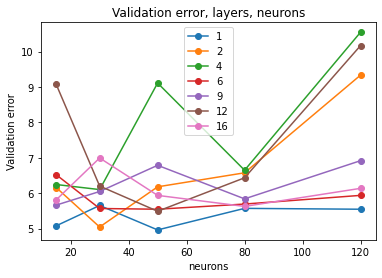

In [77]:
# Visualise MLP validation errors for all layer and neuron counts
for i, n_layers in enumerate(num_layers):
    start =  i   *len(num_neurons)
    end   = (i+1)*len(num_neurons)
    plt.plot(num_neurons, mlp_val_errors[start:end], 'o-')
plt.title('Validation error, layers, neurons')
plt.xlabel('neurons')
plt.ylabel('Validation error')
plt.legend(num_layers)

In [171]:
# Plot the results of the validation set
# From the above visualisation, choose 6 layers + 50 neurons or 80 neurons
# coords (3, 2) -> 3*5 + 2 = [17]
# or [18]
choice = 17
n_layers               = mlp_predictors[choice][0]
n_neurons              = mlp_predictors[choice][1]
selected_mlp_predictor = mlp_predictors[choice][2]
mserr_mlp = mlp_val_errors[choice]

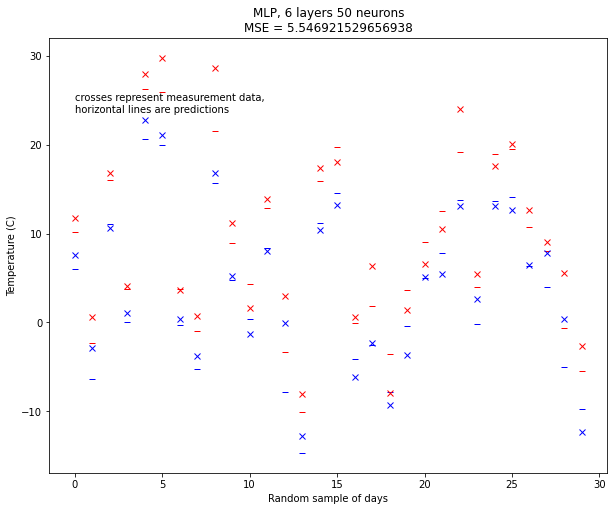

In [172]:
plt.figure(figsize=(10,8))
plt.title(f'MLP, {n_layers} layers {n_neurons} neurons' + 
          f'\nMSE = {mserr_mlp}')
plt.text(0, 0.9*max(yhat_mlp_val[0:30, 1]), 'crosses represent measurement data, \nhorizontal lines are predictions')
plt.xlabel('Random sample of days')
plt.ylabel('Temperature (C)')
plt.plot(yhat_mlp_val[0:30, 0], 'b_')
plt.plot(yhat_mlp_val[0:30, 1], 'r_')
plt.plot(       y_val[0:30, 0], 'bx')
plt.plot(       y_val[0:30, 1], 'rx')

In [163]:
# polynomial regression using linear regression and kernel method, and Huber loss

degree = 0
# Training degree 4 takes a significant amount of time
# 3: 27s, 4: 574s
Huber_tr_errors, Huber_val_errors = [], []
Huber_poly_predictors = []
H_regr  = HuberRegressor(fit_intercept=False, max_iter = 100000) # NOTE: "fit_intercept=False" as we already have a constant iterm in the new feature X_poly
max_dim = 2
print('-- Polynomial regression, Huber loss --')

-- Polynomial regression, Huber loss --


In [167]:
# iterating multiple times manually
timerstart    = timeit.default_timer() #
degree        = degree + 1
poly          = PolynomialFeatures(degree=degree)     # generate polynomial features
X_train_poly  = poly.fit_transform(X_train)           # fit and transform the raw features
X_val_poly    = poly.fit_transform(X_val)

# HuberRegressor requires y to be 1-D, need to repeat this twice for each column of y
# max_dim = 2
H_regressors  = [HuberRegressor(fit_intercept=False, max_iter = 100000) for j in range(max_dim)]
y_pred_train  = []
y_pred_val    = []

for j in range(max_dim):
    H_regressors[j].fit(X_train_poly, y_train[:,j])
    #print(y_train[:,j]) #DEBUG
    #print(f'Score {H_regressors[j].score(X_train_poly, y_train[:,j]) }' ) #DEBUG
    y_pred_train.append(H_regressors[j].predict(X_train_poly))
    y_pred_val  .append(H_regressors[j].predict(X_val_poly))

## DEBUG
#print(f'DEBUG {sum(H_regressors[0].predict(X_train_poly) - H_regressors[1].predict(X_train_poly))}')
#print(f'shape of the row {np.shape([degree, H_regressors]) }' )
##
Huber_poly_predictors.append([degree, H_regressors])

y_pred_train  = np.array(y_pred_train).T
y_pred_val    = np.array(y_pred_val).T
tr_error      = mean_squared_error(y_train, y_pred_train)
val_error     = mean_squared_error(y_val, y_pred_val)

Huber_tr_errors.append(tr_error)
Huber_val_errors.append(val_error)

timerstop     = timeit.default_timer()
print(f'Degree: {degree}, Training error: {tr_error}, Validation error: {val_error},',
      f'Time taken: {timerstop - timerstart}')

if val_error / tr_error > 100:
    print(f'[!] Significant difference in validation and training errors:',
          f'\n{val_error} / {tr_error} = {val_error/tr_error}')

Degree: 4, Training error: 4.115778415392128, Validation error: 4.049198197881825, Time taken: 574.2097668703645


In [168]:
print('Training errors, Validation errors')
Huber_errors = np.array([Huber_tr_errors, Huber_val_errors]).T
print(Huber_errors)

Training errors, Validation errors
[[4.19024753 4.21648787]
 [4.12503779 4.10957624]
 [4.14329055 4.09798493]
 [4.11577842 4.0491982 ]]


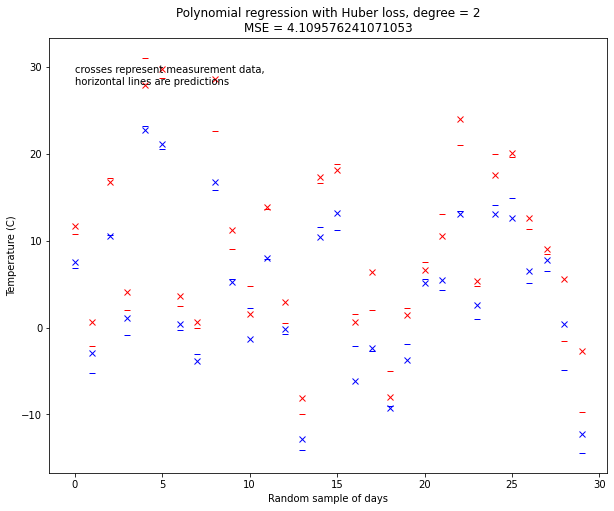

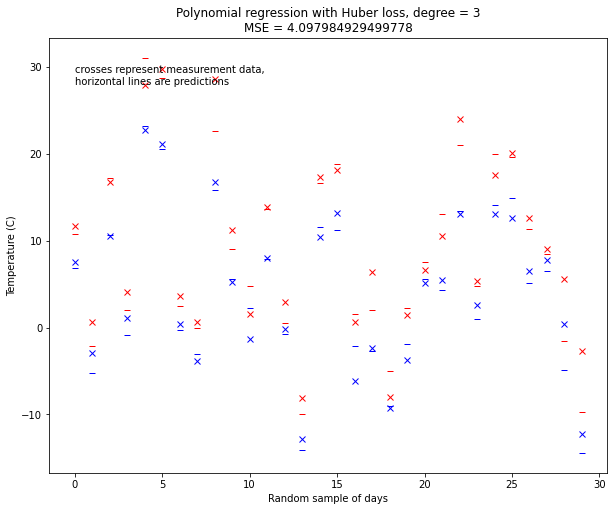

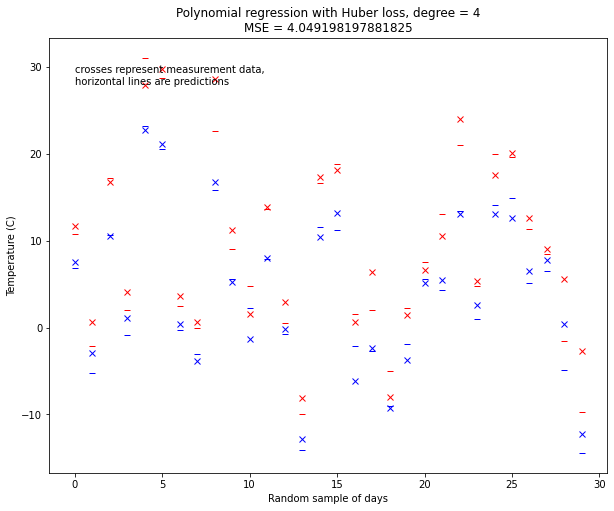

In [170]:
# Plot the validation results
# Interestingly enough, degree 3 with Huber loss does not show signs of overfitting. 
# In fact, even degree 4 does not either.
choice = [1, 2, 3]
for i in choice:
    deg                  = Huber_poly_predictors[i][0]
    selected_H_predictor = Huber_poly_predictors[i][1]
    comment = '''
    yhat_H_val = []
    polyH = PolynomialFeatures(degree=degree)
    for i in range(max_dim):
        H_regr     = selected_H_predictor[i]
        X_polyH_val = polyH.fit_transform(X_val)
        yhat_H_val.append(H_regr.predict(X_polyH_val))
    yhat_H_val = np.array(yhat_H_val).T
    '''
    mserr_H    = Huber_val_errors[i]

    plt.figure(figsize=(10,8))
    plt.title(f'Polynomial regression with Huber loss, degree = {deg}' + 
              f'\nMSE = {mserr_H}')
    plt.text(0, 0.9*max(yhat_H_val[0:30, 1]), 'crosses represent measurement data, \nhorizontal lines are predictions')
    plt.xlabel('Random sample of days')
    plt.ylabel('Temperature (C)')
    plt.plot(yhat_H_val[0:30, 0], 'b_')
    plt.plot(yhat_H_val[0:30, 1], 'r_')
    plt.plot(     y_val[0:30, 0], 'bx')
    plt.plot(     y_val[0:30, 1], 'rx')

In [181]:
# Final chosen predictor
# Polynomial regression with Huber loss, degree 4
deg        = Huber_poly_predictors[3][0]
predictors = Huber_poly_predictors[3][1]
# Applying the test set
poly       = PolynomialFeatures(degree=deg)
X_test_poly= poly.fit_transform(X_test)
yhat_test  = []
for j in range(max_dim):
    yhat_test.append(predictors[j].predict(X_test_poly))
yhat_test = np.array(yhat_test).T
mserr = mean_squared_error(yhat_test, y_test)

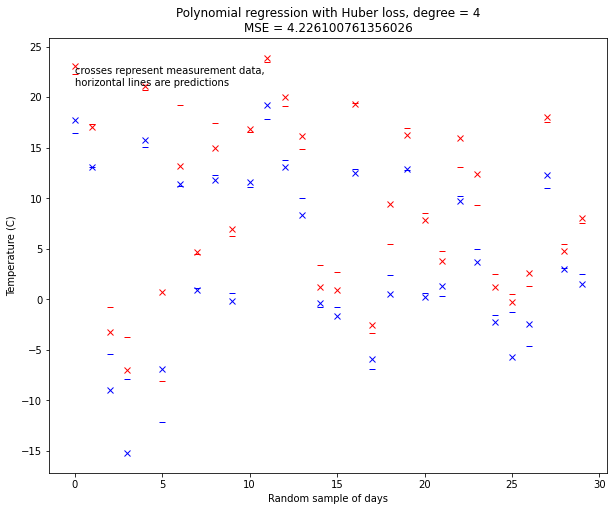

In [184]:
# Visualisation
plt.figure(figsize=(10,8))
plt.title(f'Polynomial regression with Huber loss, degree = {deg}' + 
          f'\nMSE = {mserr}')
plt.text(0, 0.9*max(yhat_test[0:30, 1]), 'crosses represent measurement data, \nhorizontal lines are predictions')
plt.xlabel('Random sample of days')
plt.ylabel('Temperature (C)')
plt.plot(yhat_test[0:30, 0], 'b_')
plt.plot(yhat_test[0:30, 1], 'r_')
plt.plot(   y_test[0:30, 0], 'bx')
plt.plot(   y_test[0:30, 1], 'rx')

In [150]:
# Comment blocks, discarded code
# data2.head(30)
debug = '''
shape      = data_pd.shape
testdata   = data_pd.dropna(axis = 0, how = 'any')
shape_test = testdata.shape
print('shapes: ', shape, ' , ', shape_test)

time_counts = data_pd['time'].value_counts()
print('Time counts \n', time_counts)
'''
debug = ''''''

date_manipulation_tests = '''
y = 2020
m = 2
d = 28
today   = #nextday#datetime.datetime(y, m, d)
nextday = today + datetime.timedelta(days = 1)
print('Day ', y, m, d, '\nNext day ', nextday)

# https://docs.python.org/3/library/datetime.html
nextdaylist = nextday.year # datetime has attributes: year, month, day
print(nextdaylist)
'''
#FMIRawData.head(5)
#np.shape(FMIRawData)# (, )
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html?highlight=series#pandas.Series
#FMIRawData.tail(1)['m'].values # returns as an array
#FMIRawData.columns
#Index(['Year', 'm', 'd', 'Time', 'Time zone', 'Precipitation amount (mm)', 'Air temperature (degC)'], dtype='object')